In [1346]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [1347]:
cwd = os.getcwd()
data_file_name = "/dataset/day.csv"
dataset = pd.read_csv(cwd + data_file_name)
dataset.shape #(731, 16)

(731, 16)

In [1348]:
# convert string to datetime
dataset.dteday = dataset.dteday.apply(lambda x:pd.to_datetime(x))
dataset = dataset.drop(['instant'], axis = 1)
dataset = dataset.rename(columns={'registered': 'regist'})

dataset[dataset.dteday == '2012-10-29'].index
dataset = dataset.drop(dataset[dataset.dteday == '2012-10-29'].index)


In [1349]:
amendWeathersit3_4 = ['2011-01-26', '2011-04-16', '2011-09-07', '2011-09-08',
                     '2011-10-29', '2011-12-07', '2012-10-29',
                     '2012-10-30', '2012-12-26']
amendWeathersit2_3 = ['2012-04-22']
dataset.loc[dataset.dteday.isin(amendWeathersit3_4), 'weathersit'] = 4
dataset.loc[dataset.dteday.isin(amendWeathersit2_3), 'weathersit'] = 3

In [1350]:
# calculate the ahead n-7 to n-2 days average number
def calcAvgShift(dfCol, period, exclude):
    try:
        summary = dfCol.rolling(period).mean()
        if period is None:
            return dfCol
        if exclude is None:
            return summary
        mean = dfCol.shift(exclude).rolling(period, 1).mean()
        return mean.apply(lambda x: round(x, 3))
    except Exception as e:
        print("error:" + str(e))
        
def calcMaxShift(dfCol, period, exclude):
    try:
        summary = dfCol.rolling(period).max()
        if period is None:
            return dfCol
        if exclude is None:
            return summary
        maximum = dfCol.shift(exclude).rolling(period, 1).max()
        return maximum.apply(lambda x: round(x, 3))
    except Exception as e:
        print("error:" + str(e))
        
def calcMinShift(dfCol, period, exclude):
    try:
        summary = dfCol.rolling(period).min()
        if period is None:
            return dfCol
        if exclude is None:
            return summary
        minimum = dfCol.shift(exclude).rolling(period, 1).min()
        return minimum.apply(lambda x: round(x, 3))
    except Exception as e:
        print("error:" + str(e))

In [1351]:
def calcIncreaseRatio(pre, comp):
    inc = (comp - pre) / pre
    return round(inc, 3)

In [1352]:
dataset['casual_lag2'] = dataset['casual'].shift(2)
dataset['regist_lag2'] = dataset['regist'].shift(2)
dataset['cnt_lag2'] = dataset['cnt'].shift(2)
dataset['temp_inc'] = calcIncreaseRatio(dataset.temp.shift(1), dataset.temp)

dataset['casual_avg_aheadWeek'] = calcAvgShift(dataset.casual, 7, 2)
dataset['regist_avg_aheadWeek'] = calcAvgShift(dataset.regist, 7, 2)
dataset['cnt_avg_aheadWeek'] = calcAvgShift(dataset.cnt, 7, 2)

dataset['casual_avg_ahead3days'] = calcAvgShift(dataset.casual, 5, 2)
dataset['regist_avg_ahead3days'] = calcAvgShift(dataset.regist, 5, 2)
dataset['cnt_avg_ahead3days'] = calcAvgShift(dataset.cnt, 5, 2)

dataset['casual_avg_aheadMonth'] = calcAvgShift(dataset.casual, 31, 2)
dataset['regist_avg_aheadMonth'] = calcAvgShift(dataset.regist, 31, 2)
dataset['cnt_avg_aheadMonth'] = calcAvgShift(dataset.cnt, 31, 2)

dataset['casual_median_LastWeek'] = dataset.casual.shift(2).rolling(7, 1).median()
dataset['regist_median_LastWeek'] = dataset.regist.shift(2).rolling(7, 1).median()
dataset['cnt_median_LastWeek'] = dataset.cnt.shift(2).rolling(7, 1).median()


dataset['casual_inc_ratio_lag2'] = calcIncreaseRatio(dataset.casual.shift(3), dataset.casual.shift(2)) 
dataset['regist_inc_ratio_lag2'] = calcIncreaseRatio(dataset.regist.shift(3), dataset.regist.shift(2)) 
dataset['cnt_inc_ratio_lag2'] = calcIncreaseRatio(dataset.cnt.shift(3), dataset.cnt.shift(2))

# dataset['casual_inc_ratio_max_lastweek'] = calcIncreaseRatio(calcMaxShift(dataset.casual, 10))

dataset['casual_max_LastWeek'] = dataset.casual.shift(2).rolling(7, 1).max()
dataset['regist_max_LastWeek'] = dataset.regist.shift(2).rolling(7, 1).max()
dataset['cnt_max_LastWeek'] = dataset.cnt.shift(2).rolling(7, 1).max()

dataset['casual_inc_ratio_weekly_max'] = calcIncreaseRatio(calcMaxShift(dataset.casual, 6, 3), dataset.casual_lag2)
dataset['regist_inc_ratio_weekly_max'] = calcIncreaseRatio(calcMaxShift(dataset.regist, 6, 3), dataset.regist_lag2)
dataset['cnt_inc_ratio_weekly_max'] = calcIncreaseRatio(calcMaxShift(dataset.cnt, 6, 3), dataset.cnt_lag2)

dataset['casual_inc_ratio_weekly_min'] = calcIncreaseRatio(calcMinShift(dataset.casual, 6, 3), dataset.casual_lag2)
dataset['regist_inc_ratio_weekly_min'] = calcIncreaseRatio(calcMinShift(dataset.regist, 6, 3), dataset.regist_lag2)
dataset['cnt_inc_ratio_weekly_min'] = calcIncreaseRatio(calcMinShift(dataset.cnt, 6, 3), dataset.cnt_lag2)

dataset['casual_inc_ratio_monthly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.casual, 31, 2), dataset.casual_lag2)
dataset['regist_inc_ratio_monthly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.regist, 31, 2), dataset.regist_lag2)
dataset['cnt_inc_ratio_monthly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.cnt, 31, 2), dataset.cnt_lag2)

dataset['casual_inc_ratio_weekly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.casual, 7, 2), dataset.casual_lag2)
dataset['regist_inc_ratio_weekly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.regist, 7, 2), dataset.regist_lag2)
dataset['cnt_inc_ratio_weekly_avg'] = calcIncreaseRatio(calcAvgShift(dataset.cnt, 7, 2), dataset.cnt_lag2)

# xgboost 重要变量
dataset['casual_lastWeekday'] = dataset.casual.shift(7)
dataset['regist_lastWeekday'] = dataset.regist.shift(7)
dataset['cnt_lastWeekday'] = dataset.cnt.shift(7)

dataset['casual_inc_ratio'] = ((dataset['casual'] - dataset['casual_lag2']) / dataset['casual_lag2']).apply(lambda x:round(x, 3))
dataset['regist_inc_ratio'] = ((dataset['regist'] - dataset['regist_lag2']) / dataset['regist_lag2']).apply(lambda x:round(x, 3))
dataset['cnt_inc_ratio'] = ((dataset['cnt'] - dataset['cnt_lag2']) / dataset['cnt_lag2']).apply(lambda x:round(x, 3))

dataset.to_csv("./totalBikeSharing.csv", index=False)




In [1353]:
# one hot encode dummy encode
dummy_season = pd.get_dummies(dataset.season, prefix="season")
dummy_weathersit = pd.get_dummies(dataset.weathersit, prefix="weathersit")
dummy_weekday = pd.get_dummies(dataset.weekday, prefix="weekday")
dataset = pd.concat([dataset, dummy_season, dummy_weathersit, dummy_weekday], axis = 1)

In [1354]:
# drop columns and mark some columns
casual_cols = dataset.filter(like = 'casual').columns.values.tolist() # filter the column name contain casual
regist_cols = dataset.filter(like = 'regist').columns.values.tolist()
cnt_cols = dataset.filter(like = 'cnt').columns.values.tolist()

oneHotCols = dataset.filter(regex='workingday|holiday|weekday_|weathersit_|season_').columns.values
exclude_dict = {'casual': regist_cols + cnt_cols, 'regist': casual_cols + cnt_cols, 'cnt': casual_cols + regist_cols}


In [1355]:
# split train and test
target = 'cnt'
target_col_name = target + '_inc_ratio'

train = dataset[dataset.dteday < datetime(2012, 1, 1)]
test = dataset[~(dataset.dteday < datetime(2012, 1, 1))]

train_Y_origin = train[target]
test_Y_origin = test[target]

train_Y = train[target_col_name]
test_Y = test[target_col_name]

drop_col = ['dteday', 'weekday', 'yr', 'mnth', 'holiday', \
            'season', 'weathersit', 'cnt', 'atemp', 'windspeed',
           ]
drop_col.extend([target_col_name, target])

drop_col.extend(list(exclude_dict[target]))

train_X = train.drop(drop_col, axis = 1)
test_X = test.drop(drop_col, axis = 1)
standCols = [i for i in train_X.columns.values if i not in oneHotCols]
standCols

['temp',
 'hum',
 'cnt_lag2',
 'temp_inc',
 'cnt_avg_aheadWeek',
 'cnt_avg_ahead3days',
 'cnt_avg_aheadMonth',
 'cnt_median_LastWeek',
 'cnt_inc_ratio_lag2',
 'cnt_max_LastWeek',
 'cnt_inc_ratio_weekly_max',
 'cnt_inc_ratio_weekly_min',
 'cnt_inc_ratio_monthly_avg',
 'cnt_inc_ratio_weekly_avg',
 'cnt_lastWeekday']

In [1356]:
train_X = train_X[7:]
train_Y = train_Y[7:]

# df.dropna(axis=0,how='any') #drop all rows that have any NaN values
# list(set(np.where(np.isnan(train_X))[0]))
# train_Y = train_Y.drop(set(np.where(np.isnan(train_X))[0]), axis =0)
# train_X = train_X.drop(set(np.where(np.isnan(train_X))[0]), axis =0)

In [1357]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_X[standCols])
train_X.loc[:, standCols] = scaler.transform(train_X[standCols])
test_X.loc[:, standCols] = scaler.transform(test_X[standCols])

array([ True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

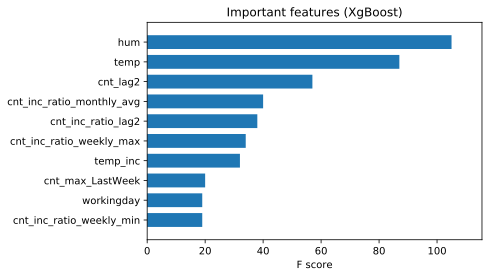

In [1358]:

from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance, plot_tree, to_graphviz

regr = XGBRegressor()
regr.fit(train_X, train_Y)

regr.feature_importances_
plot_importance(regr, max_num_features=10,  height=0.7,
                    title = 'Important features (XgBoost)',
                   grid = False, ylabel="", show_values=False)
regr.feature_importances_ > 0.03

In [1359]:
# selected_features = list(train_X.columns[regr.feature_importances_ > 0.03])
# train_X = train_X[selected_features]
# train_X
# test_X = test_X[selected_features]

In [1360]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from keras import regularizers

EPOCHS = 20
BATCH_SIZE = 3


model = Sequential()
model.add(Dense(train_X.shape[1], input_dim = train_X.shape[1], 
                kernel_initializer='random_uniform', 
                bias_initializer='ones',
                activation='relu'))
model.add(Dropout(0.25))
# model.add(Dense(train_X.shape[1], kernel_initializer='random_uniform',
#                 bias_initializer='ones',
#                 activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(15, kernel_initializer='random_uniform',
                bias_initializer='ones',
                activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=EPOCHS, validation_data=(test_X, test_Y), batch_size=BATCH_SIZE, verbose=2)
train_Y_prediction = model.predict(train_X)
test_Y_prediction = model.predict(test_X)
model.summary()
nnModel = model




Train on 358 samples, validate on 365 samples
Epoch 1/20
 - 2s - loss: 0.3233 - val_loss: 0.2771
Epoch 2/20
 - 0s - loss: 0.2367 - val_loss: 0.2029
Epoch 3/20
 - 0s - loss: 0.1682 - val_loss: 0.1781
Epoch 4/20
 - 1s - loss: 0.1421 - val_loss: 0.1516
Epoch 5/20
 - 1s - loss: 0.1230 - val_loss: 0.1559
Epoch 6/20
 - 1s - loss: 0.1252 - val_loss: 0.1465
Epoch 7/20
 - 0s - loss: 0.1099 - val_loss: 0.1289
Epoch 8/20
 - 0s - loss: 0.1148 - val_loss: 0.1292
Epoch 9/20
 - 0s - loss: 0.1177 - val_loss: 0.1389
Epoch 10/20
 - 0s - loss: 0.1015 - val_loss: 0.1160
Epoch 11/20
 - 1s - loss: 0.0997 - val_loss: 0.1502
Epoch 12/20
 - 0s - loss: 0.1045 - val_loss: 0.1243
Epoch 13/20
 - 0s - loss: 0.1125 - val_loss: 0.1136
Epoch 14/20
 - 0s - loss: 0.0876 - val_loss: 0.1425
Epoch 15/20
 - 0s - loss: 0.0827 - val_loss: 0.1414
Epoch 16/20
 - 0s - loss: 0.0853 - val_loss: 0.1214
Epoch 17/20
 - 0s - loss: 0.1021 - val_loss: 0.1590
Epoch 18/20
 - 0s - loss: 0.0874 - val_loss: 0.1364
Epoch 19/20
 - 1s - loss: 0

In [1151]:
lagColumnName = target + '_lag2'
predRationColumnName = target + '_pred_ratio'
predValueColumnName = target + '_pred_value'
test[predRationColumnName] = test_Y_prediction.flatten()
test[predValueColumnName] = test[lagColumnName] * ( 1 + test[predRationColumnName])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


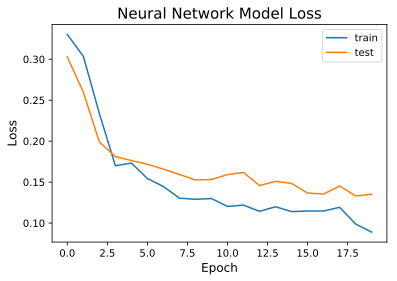

In [1152]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Model Loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.savefig('training_NN.pdf', bbox_inches='tight')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

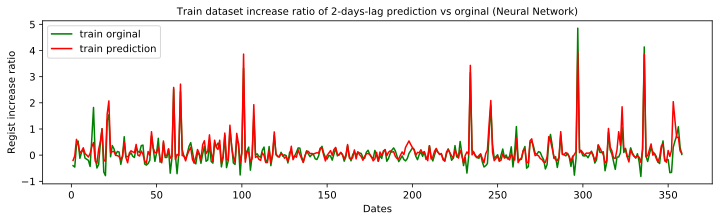

In [1361]:
result_train = pd.DataFrame({'train_Y':train_Y, \
              'pred_train_Y':train_Y_prediction.flatten()
             })
time = [x + 1 for x in range(0, result_train.shape[0])]


# pd.DataFrame({'train_Y': train_Y,\
#               'pred_train_Y': train_Y_prediction.flatten()
#              })
plt.figure(figsize=(12,3))
plt.plot(time, result_train.train_Y, color='green', label='train orginal')
plt.plot(time, result_train.pred_train_Y, color='red', label='train prediction')
plt.ylabel('Regist increase ratio', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.title('Train dataset increase ratio of 2-days-lag prediction vs orginal (Neural Network)', fontsize = 10)
plt.savefig('train_increase_ratio_origin_vs_prediction.pdf', bbox_inches='tight')
plt.legend(loc='upper left')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.show()

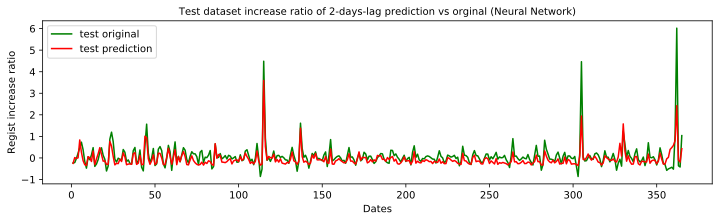

In [1362]:
# test_Y_prediction.flatten()



result = pd.DataFrame({'test_Y':test_Y, \
              'pred_test_Y':test_Y_prediction.flatten()
             })

time = [x + 1 for x in range(0, result.shape[0])]


# pd.DataFrame({'train_Y': train_Y,\
#               'pred_train_Y': train_Y_prediction.flatten()
#              })
plt.figure(figsize=(12,3))
plt.plot(time, result.test_Y, color='green', label='test original')
plt.plot(time, result.pred_test_Y, color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Regist increase ratio', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')
plt.title('Test dataset increase ratio of 2-days-lag prediction vs orginal (Neural Network)', fontsize = 10)
plt.savefig('test_increase_ratio_origin_vs_prediction.pdf', bbox_inches='tight')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.show()

In [1364]:
test

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
365 2012-01-01       1   1     1        0        0           0           1   
366 2012-01-02       1   1     1        1        1           0           1   
367 2012-01-03       1   1     1        0        2           1           1   
368 2012-01-04       1   1     1        0        3           1           2   
369 2012-01-05       1   1     1        0        4           1           1   
370 2012-01-06       1   1     1        0        5           1           1   
371 2012-01-07       1   1     1        0        6           0           1   
372 2012-01-08       1   1     1        0        0           0           1   
373 2012-01-09       1   1     1        0        1           1           2   
374 2012-01-10       1   1     1        0        2           1           1   
375 2012-01-11       1   1     1        0        3           1           2   
376 2012-01-12       1   1     1        0        4           1           2   
377 2012-01-13       1   1     1        0        5           1           1   
378 2012-01-14       1   1     1        0        6           0           1   
379 2012-01-15       1   1     1        0        0           0           1   
380 2012-01-16       1   1     1        1        1           0           1   
381 2012-01-17       1   1     1        0        2           1           2   
382 2012-01-18       1   1     1        0        3           1           1   
383 2012-01-19       1   1     1        0        4           1           1   
384 2012-01-20       1   1     1        0        5           1           2   
385 2012-01-21       1   1     1        0        6           0           2   
386 2012-01-22       1   1     1        0        0           0           2   
387 2012-01-23       1   1     1        0        1           1           2   
388 2012-01-24       1   1     1        0        2           1           1   
389 2012-01-25       1   1     1        0        3           1           1   
390 2012-01-26       1   1     1        0        4           1           2   
391 2012-01-27       1   1     1        0        5           1           2   
392 2012-01-28       1   1     1        0        6           0           1   
393 2012-01-29       1   1     1        0        0           0           1   
394 2012-01-30       1   1     1        0        1           1           1   
..         ...     ...  ..   ...      ...      ...         ...         ...   
701 2012-12-02       4   1    12        0        0           0           2   
702 2012-12-03       4   1    12        0        1           1           1   
703 2012-12-04       4   1    12        0        2           1           1   
704 2012-12-05       4   1    12        0        3           1           1   
705 2012-12-06       4   1    12        0        4           1           1   
706 2012-12-07       4   1    12        0        5           1           2   
707 2012-12-08       4   1    12        0        6           0           2   
708 2012-12-09       4   1    12        0        0           0           2   
709 2012-12-10       4   1    12        0        1           1           2   
710 2012-12-11       4   1    12        0        2           1           2   
711 2012-12-12       4   1    12        0        3           1           2   
712 2012-12-13       4   1    12        0        4           1           1   
713 2012-12-14       4   1    12        0        5           1           1   
714 2012-12-15       4   1    12        0        6           0           1   
715 2012-12-16       4   1    12        0        0           0           2   
716 2012-12-17       4   1    12        0        1           1           2   
717 2012-12-18       4   1    12        0        2           1           1   
718 2012-12-19       4   1    12        0        3           1           1   
719 2012-12-20       4   1    12        0        4           1           2   
720 2012-12-21       1   1    

In [1365]:
# test['prediction_value']
# test['regist']
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure()
ax = plt.scatter(test[predValueColumnName], test[target], s = 10)
plt.plot([x for x in range(0,7000)], [x for x in range(0, 7000)])
plt.ylabel('test original', fontsize = 10)
plt.xlabel('test prediction', fontsize = 10)
mse_NN = mean_squared_error(test[predValueColumnName], test[target])
mse = mse_NN**(0.5)
plt.title('Neural Network test prediction vs orginal, RMSE = %f'%mse, fontsize = 10)

plt.savefig('test_origin_vs_prediction.pdf', bbox_inches='tight')

plt.show()
mse_NN**(0.5)

KeyError: 'cnt_pred_value'

In [1156]:
revenuePerBike = 3
loanCostPerBike = 2
profit = pd.DataFrame({predValueColumnName:test[predValueColumnName], \
              target:test[target]
             })
profit['revenue_daily'] = profit.apply(lambda x: revenuePerBike * min(x[target], x[predValueColumnName]), axis = 1)
profit['cost_daily'] = profit.apply(lambda x:x[predValueColumnName] * loanCostPerBike, axis = 1)
profit['profit_daily'] = profit.revenue_daily - profit.cost_daily
profit['test_lag2'] = test[lagColumnName]
profit['benchmark_profit'] = profit.apply(
    lambda x: (min(x['test_lag2'], x[target]) * revenuePerBike - loanCostPerBike * x['test_lag2']),
    axis = 1
) 
totalProfit = profit.profit_daily.sum()

profit.to_csv("./nn_profit_regist.csv", index=False)
totalProfit
# profit.benchmark_profit.sum()


1579928.2766740918

<Container object of 12 artists>

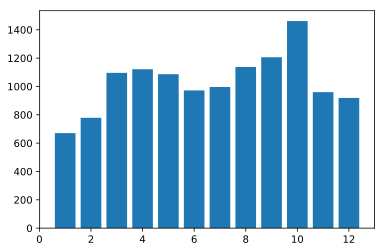

In [1192]:


profit['abs_error'] = abs(profit.cnt - profit.cnt_pred_value)
profit['timeline'] = test.dteday
profit['month'] = profit['timeline'].apply(lambda x:x.month)
monthly = profit.groupby('month')['abs_error'].mean()
monthly
plt.figure()
plt.bar(monthly.index, monthly)


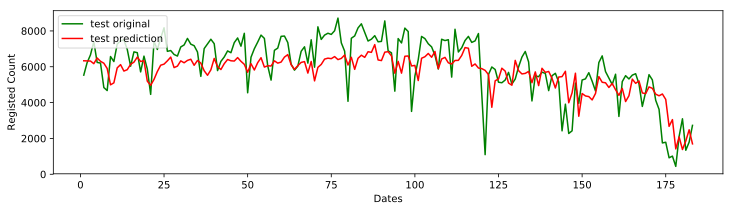

In [1097]:
time = [x + 1 for x in range(0, result.shape[0])]
plt.figure(figsize=(12,3))
plt.plot(time, profit[target], color='green', label='test original')
plt.plot(time, profit[predValueColumnName], color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Registed Count', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.savefig('test_origin_vs_prediction_timeline.pdf', bbox_inches='tight')
plt.show()

In [1293]:
def restoreRatio2Result(pred, raw_lag):
    return (pred + 1) * raw_lag

def constructResultDf(raw_data, raw_lag, pred, target, timeline):
    revenue = 3
    loan = 2
    result = pd.DataFrame({'date': timeline, 
                           'raw_Y': raw_data,
                           'raw_lag': raw_lag,
                           'target_Y_ratio': target,
                           'pred_Y_ratio': pred,
                           'pred_Y': restoreRatio2Result(pred, raw_lag)}
                         )
    result['cost'] = result.apply(
        lambda x:x['pred_Y'] * loan, axis = 1
    )
    result['revenue'] = result.apply(
        lambda x:revenue * min(x['pred_Y'], x['raw_Y']), axis = 1
    )
    result['profit'] = result['revenue'] - result['cost']
    result['benchmark_profit'] = result.apply(
        lambda x: (min(x['raw_lag'], x['raw_Y']) * revenue - loan * x['raw_lag']),
        axis = 1
    )
    return result

def plotGraph(x, *ys, xaxis = 'x', yaxis = 'y', title = 'Figure', long = True):
    colors = ['green', 'red', 'yellow', 'blue', 'purple']
    if long:
        plt.figure(figsize=(12,3))
    else: 
        plt.figure()
    for i in range(len(ys)):
        if i == 0:
            plt.plot(x, ys[i], c = 'green', label = 'orginial')
        else:
            plt.plot(x, ys[i], c= colors[i])
#     plt.plot(x, ys[1], color='green', label='test original')
#     plt.plot(time, test['xgb'], color='red', label='test prediction')
    plt.ylabel(yaxis, fontsize = 10)
    plt.xlabel(xaxis, fontsize = 10)
    plt.legend(loc='upper left')
    plt.title(title)
#     axes = plt.gca()
#     axes.set_ylim([-1,5])
    plt.savefig('%s.pdf'%title, bbox_inches='tight')
    plt.show()

### Single model -- XGBoost, tunning the parameters

In [1294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [1295]:
train_xgboost_X = train_X[['workingday', 'temp', 'hum', 'cnt_lag2', 'temp_inc',
       'cnt_avg_aheadWeek', 'cnt_avg_ahead3days', 'cnt_avg_aheadMonth',
       'cnt_median_LastWeek', 'cnt_inc_ratio_lag2',
       'cnt_inc_ratio_monthly_avg', 'cnt_inc_ratio_weekly_avg',
       'cnt_lastWeekday', 'season_1', 'season_2', 'season_3', 'season_4',
       'weathersit_1', 'weathersit_2', 'weathersit_3']]
test_xgboost_X = test_X[['workingday', 'temp', 'hum', 'cnt_lag2', 'temp_inc',
       'cnt_avg_aheadWeek', 'cnt_avg_ahead3days', 'cnt_avg_aheadMonth',
       'cnt_median_LastWeek', 'cnt_inc_ratio_lag2',
       'cnt_inc_ratio_monthly_avg', 'cnt_inc_ratio_weekly_avg',
       'cnt_lastWeekday', 'season_1', 'season_2', 'season_3', 'season_4',
       'weathersit_1', 'weathersit_2', 'weathersit_3']]

train_xgboost_X

xgbModel = xgboost.XGBRegressor(n_estimators=100, 
                           learning_rate=0.09, 
                           gamma=0.1,
                           subsample=0.51,
                           colsample_bytree=0.9, 
                           max_depth=8,
                           alpha=1,
                           reg_lambda = 9
                          )
xgbModel.fit(train_xgboost_X,train_Y)




XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.1, learning_rate=0.09,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=9, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.51)

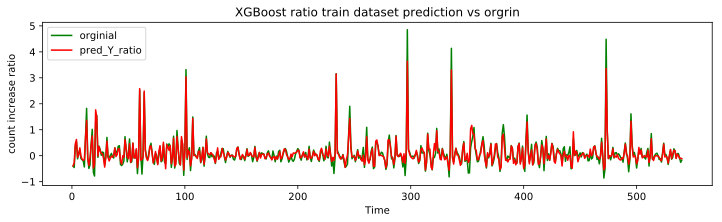

In [1296]:
train_pred = xgbModel.predict(train_xgboost_X)
res_train = constructResultDf(train.cnt[7:], train.cnt_lag2[7:], train_pred, train_Y, train.dteday[7:])
time = [x + 1 for x in range(0, train_pred.shape[0])]
plotGraph(time, res_train.target_Y_ratio, res_train.pred_Y_ratio, xaxis = 'Time', yaxis = 'count increase ratio',
         title = 'XGBoost ratio train dataset prediction vs orgrin', long = True)


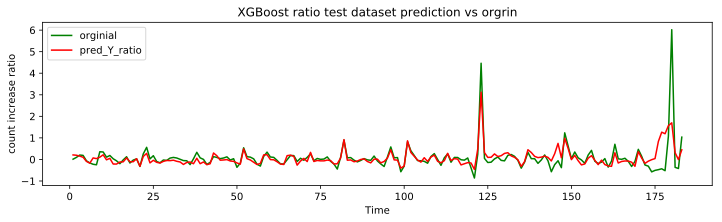

In [1297]:
predictions = xgbModel.predict(test_xgboost_X)
res = constructResultDf(test.cnt, test.cnt_lag2, predictions, test_Y, test.dteday)
time = [x + 1 for x in range(0, predictions.shape[0])]
plotGraph(time, res.target_Y_ratio, res.pred_Y_ratio, xaxis = 'Time', yaxis = 'count increase ratio',
         title = 'XGBoost ratio test dataset prediction vs orgrin', long = True)

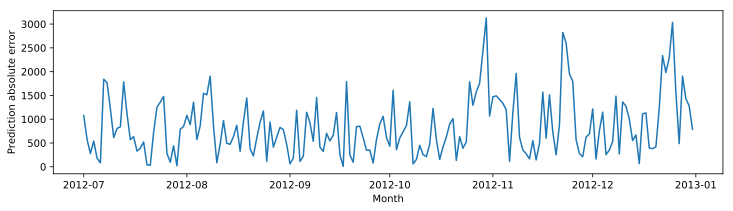

In [1298]:
res

res['abs_error'] = abs(res.raw_Y - res.pred_Y)
res['timeline'] = test.dteday
res['month'] = res['timeline'].apply(lambda x:x.month)
# monthly = res.groupby('month')['abs_error'].mean()
plt.figure(figsize=(12, 3))
plt.plot(res.timeline, res.abs_error)
plt.xlabel('Month')
plt.ylabel('Prediction absolute error')
res.to_csv('./2012-0.5year.csv')

month
7      726.293540
8      799.073526
9      607.732280
10     825.428219
11     994.093573
12    1060.242416
Name: abs_error, dtype: float64

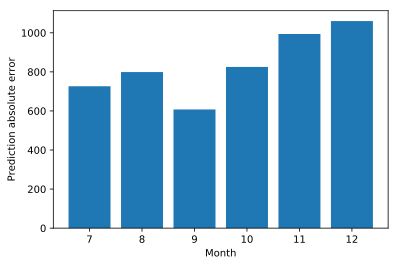

In [1299]:
res

res['abs_error'] = abs(res.raw_Y - res.pred_Y)
res['timeline'] = test.dteday
res['month'] = res['timeline'].apply(lambda x:x.month)
monthly = res.groupby('month')['abs_error'].mean()
monthly
plt.figure()
plt.bar(monthly.index, monthly)
plt.xlabel('Month')
plt.ylabel('Prediction absolute error')
monthly

In [1200]:

res['abs_error'] = abs(res.pred_Y - res.raw_Y)
res['timeline'] = test.dteday
res['month'] = res['timeline'].apply(lambda x:x.month)
res.groupby('month')['abs_error'].mean()


month
1      533.092743
2      592.308171
3      880.368966
4      790.415974
5      848.561608
6      636.717833
7      800.047721
8      577.482097
9      605.472012
10     984.578574
11     865.261265
12    1021.617998
Name: abs_error, dtype: float64

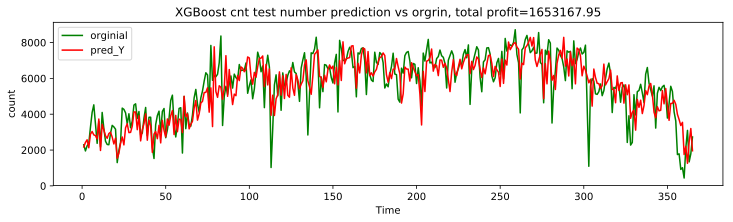

In [1201]:
plotGraph(time, res.raw_Y, res.pred_Y, xaxis = 'Time', yaxis = 'count',
         title = 'XGBoost cnt test number prediction vs orgrin, total profit=%s'%round(res.profit.sum(),2), long = True)




Text(0.5,1,'Neural Network test prediction vs orginal, RMSE = 1000.183891')

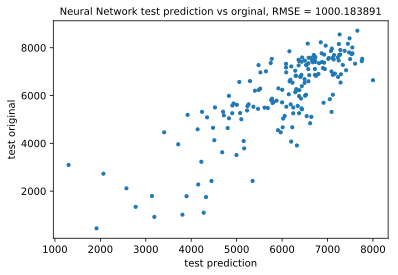

In [1106]:
plt.figure()
ax = plt.scatter(res.pred_Y, res.raw_Y, s = 10)
plt.ylabel('test original', fontsize = 10)
plt.xlabel('test prediction', fontsize = 10)
mse_NN = mean_squared_error(res.raw_Y, res.pred_Y)
mse = mse_NN**(0.5)
plt.title('Neural Network test prediction vs orginal, RMSE = %f'%mse, fontsize = 10)


In [1107]:
from keras.models import load_model
nnModel.save('nn_model.h5')
xgbModel

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.1, learning_rate=0.09,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=9, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

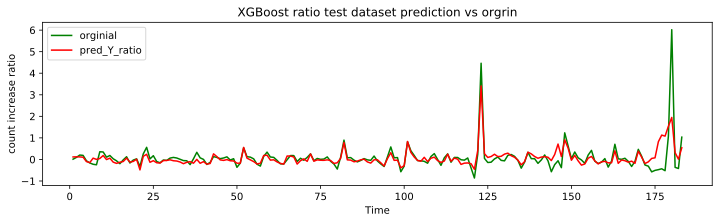

In [1108]:
predictions_xgboost = xgbModel.predict(test_X)
res = constructResultDf(test.cnt, test.cnt_lag2, predictions_xgboost, test_Y, test.dteday)
time = [x + 1 for x in range(0, predictions.shape[0])]
plotGraph(time, res.target_Y_ratio, res.pred_Y_ratio, xaxis = 'Time', yaxis = 'count increase ratio',
         title = 'XGBoost ratio test dataset prediction vs orgrin', long = True)

In [1109]:
xgboost_num = res.pred_Y

In [1110]:

predictions_nn = nnModel.predict(test_X)
predictions_nn = predictions_nn.flatten()
res = constructResultDf(test.cnt, test.cnt_lag2, predictions_nn, test_Y, test.dteday)
nn_num = res.pred_Y


In [1111]:
percent = [0.01 * i for i in range(0, 100)]

In [1112]:
rr = {}
for per in percent:
    revenue = 3
    loan = 2
    avg = per * xgboost_num + (1-per) *nn_num
    result = pd.DataFrame({'avg': avg, 'cnt': test.cnt})  
    result['prof'] = result.apply(
        lambda x: (min(x['avg'], x['cnt']) * revenue - loan * x['avg']),
        axis = 1
    )
    rr[per] = result.prof.sum()

In [1113]:
max(rr, key=rr.get)
(max(rr, key=rr.get), rr.get(max(rr, key=rr.get)))

(0.66, 902821.7525872802)

## stack ensemble

In [413]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
for train_index, holdout_index in kfold.split(train_X, train_Y):
    print(train_index)
    

[ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 31